In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from common import *
import tensorflow as tf

set_random_seed(RANDOM_STATE)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
    
exp_name = 'proposed27'

2022-07-22 14:05:16.405370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 14:05:16.407507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 14:05:16.407663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# 1. Load dataset

In [2]:
data_ = pd.read_csv(join(PATH.input, "train_data.csv"))
sample_submission = pd.read_csv(join(PATH.input, "sample_submission.csv"))
data_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3859200 entries, 0 to 3859199
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 382.8+ MB


# 2. Data processing

In [3]:
IN_SEQ_LEN  = 2*144
OUT_SEQ_LEN = 2*144
STRIDE      = 1
SHUFFLE     = False
VAL_SIZE    = 0.2

In [4]:
data = generate_full_timestamp(data_)

idxs_safe = data.query(f"Day >= 200-{IN_SEQ_LEN//144}").index
data1 = data.drop(idxs_safe)
data2 = data.loc[idxs_safe]

data1 = impute_data(data1)
# data1 = marking_data(data1, 0)
data1 = marking_data(data1, None).dropna()

data2 = data2.interpolate().bfill()

data_imp     = pd.concat([data1, data2])
data_imp_not = data.interpolate().bfill()

100%|██████████| 134/134 [00:08<00:00, 16.73it/s]


* Data name: Imputing
  - Number of data: 3765334
  - Number of nan rows: 0


In [5]:
df = copy(data_imp)
df

TurbID  Day Tmstamp  Wspd  Wdir   Etmp   Itmp    Ndir  Pab1  Pab2  Pab3    Prtv    Patv  \
0             1    1   00:00  6.17 -3.99  30.73  41.80   25.92  1.00  1.00  1.00   -0.25  494.66   
1             1    1   00:10  6.17 -3.99  30.73  41.80   25.92  1.00  1.00  1.00   -0.25  494.66   
2             1    1   00:20  6.27 -2.18  30.60  41.63   20.91  1.00  1.00  1.00   -0.24  509.76   
3             1    1   00:30  6.42 -0.73  30.52  41.52   20.91  1.00  1.00  1.00   -0.26  542.53   
4             1    1   00:40  6.25  0.89  30.49  41.38   20.91  1.00  1.00  1.00   -0.23  509.36   
...         ...  ...     ...   ...   ...    ...    ...     ...   ...   ...   ...     ...     ...   
3859195     134  200   23:10  4.86  4.68   9.04  10.40  174.39  0.01  0.01  0.01 -108.13  308.65   
3859196     134  200   23:20  4.46 -4.00   8.79  10.33  179.76  0.01  0.01  0.01  -93.64  221.60   
3859197     134  200   23:30  4.23 -0.08   8.74  10.22  172.35  0.01  0.01  0.01 -111.20  220.60   
3859198     134  200   23:40  4.36 -6.12   8.64  10.10  172.35  0.01  0.01  0.01 -108.04  222.15   
3859199     134  200   23:50  4.79 -3.65   8.53  10.01  168.58  0.01  0.01  0.01 -119.76  264.17   

          Time  
0            1  
1            2  
2            3  
3            4  
4            5  
...        ...  
3859195  28796  
3859196  28797  
3859197  28798  
3859198  28799  
3859199  28800  

[2980852 rows x 14 columns]

In [6]:
df = outlier_handler(df, ['Etmp', 'Itmp', 'Prtv'])

100%|██████████| 199/199 [00:09<00:00, 20.50it/s]


In [7]:
def process_features(data, lag=0, features_lag=None):
    data = copy(data)
    
    vals         = data['Wspd'].value_counts().index
    min_val      = vals[vals > 0][0]
    data['Wspd'] = data['Wspd'].clip(min_val, max(data['Wspd']))
    
    wd_rad        = np.deg2rad(data['Wdir'])
    data['WdirX'] = np.cos(wd_rad)
    data['WdirY'] = np.sin(wd_rad)
    
    data['WspdX'] = data['Wspd']*data['WdirX']
    data['WspdY'] = data['Wspd']*data['WdirY']
    
    data['Pab']  = (data['Pab1'] + data['Pab2'] + data['Pab3'])/3
    pab_rad      = np.deg2rad(data['Pab'])
    data['PabX'] = np.cos(pab_rad)
    data['PabY'] = np.sin(pab_rad)
    
    alpha = 40
    TSR1 = 1 / np.tan(np.radians((data['Pab1'] + alpha).apply(lambda x: min(x, 89)))).apply(lambda x: max(x, 0))
    TSR2 = 1 / np.tan(np.radians((data['Pab2'] + alpha).apply(lambda x: min(x, 89)))).apply(lambda x: max(x, 0))
    TSR3 = 1 / np.tan(np.radians((data['Pab3'] + alpha).apply(lambda x: min(x, 89)))).apply(lambda x: max(x, 0))
    data['TSR'] = (TSR1 + TSR2 + TSR3) / 3
    
    Bspd1 = TSR1 * data['WspdX']
    Bspd2 = TSR2 * data['WspdX']
    Bspd3 = TSR3 * data['WspdX']
    data['RPM'] = (Bspd1 + Bspd2 + Bspd3) / 3
    
    hours = data['Tmstamp'].map(lambda x: int(x.split(':')[0]) + int(x.split(':')[1]) / 60)
    data['HourX'] = np.cos(2 * np.pi * (hours / 24))
    data['HourY'] = np.sin(2 * np.pi * (hours / 24))
    
    c = 243.15
    data['Etmp_abs'] = data['Etmp'] + c
    
    if lag > 0:
        for col in features_lag:
            for lag in range(1, lag+1):
                data[f'{col}_lag{lag}'] = data[col].shift(lag)
        data.dropna(inplace=True)

    return data

df_fe = process_features(df)
df_fe

TurbID  Day Tmstamp  Wspd  Wdir   Etmp   Itmp    Ndir  Pab1  Pab2  Pab3    Prtv    Patv  \
0             1    1   00:00  6.17 -3.99  30.73  41.80   25.92  1.00  1.00  1.00   -0.25  494.66   
1             1    1   00:10  6.17 -3.99  30.73  41.80   25.92  1.00  1.00  1.00   -0.25  494.66   
2             1    1   00:20  6.27 -2.18  30.60  41.63   20.91  1.00  1.00  1.00   -0.24  509.76   
3             1    1   00:30  6.42 -0.73  30.52  41.52   20.91  1.00  1.00  1.00   -0.26  542.53   
4             1    1   00:40  6.25  0.89  30.49  41.38   20.91  1.00  1.00  1.00   -0.23  509.36   
...         ...  ...     ...   ...   ...    ...    ...     ...   ...   ...   ...     ...     ...   
3859195     134  200   23:10  4.86  4.68   9.04  10.40  174.39  0.01  0.01  0.01 -108.13  308.65   
3859196     134  200   23:20  4.46 -4.00   8.79  10.33  179.76  0.01  0.01  0.01 -108.10  221.60   
3859197     134  200   23:30  4.23 -0.08   8.74  10.22  172.35  0.01  0.01  0.01 -108.07  220.60   
3859198     134  200   23:40  4.36 -6.12   8.64  10.10  172.35  0.01  0.01  0.01 -108.04  222.15   
3859199     134  200   23:50  4.79 -3.65   8.53  10.01  168.58  0.01  0.01  0.01 -108.04  264.17   

          Time     WdirX     WdirY     WspdX     WspdY   Pab      PabX      PabY       TSR  \
0            1  0.997576 -0.069582  6.155045 -0.429323  1.00  0.999848  0.017452  1.150368   
1            2  0.997576 -0.069582  6.155045 -0.429323  1.00  0.999848  0.017452  1.150368   
2            3  0.999276 -0.038039  6.265462 -0.238505  1.00  0.999848  0.017452  1.150368   
3            4  0.999919 -0.012741  6.419479 -0.081794  1.00  0.999848  0.017452  1.150368   
4            5  0.999879  0.015533  6.249246  0.097080  1.00  0.999848  0.017452  1.150368   
...        ...       ...       ...       ...       ...   ...       ...       ...       ...   
3859195  28796  0.996666  0.081591  4.843796  0.396530  0.01  1.000000  0.000175  1.191331   
3859196  28797  0.997564 -0.069756  4.449136 -0.311114  0.01  1.000000  0.000175  1.191331   
3859197  28798  0.999999 -0.001396  4.229996 -0.005906  0.01  1.000000  0.000175  1.191331   
3859198  28799  0.994301 -0.106611  4.335151 -0.464825  0.01  1.000000  0.000175  1.191331   
3859199  28800  0.997972 -0.063661  4.780284 -0.304938  0.01  1.000000  0.000175  1.191331   

              RPM     HourX     HourY  Etmp_abs  
0        7.080570  1.000000  0.000000    273.88  
1        7.080570  0.999048  0.043619    273.88  
2        7.207590  0.996195  0.087156    273.75  
3        7.384766  0.991445  0.130526    273.67  
4        7.188935  0.984808  0.173648    273.64  
...           ...       ...       ...       ...  
3859195  5.770566  0.976296 -0.216440    252.19  
3859196  5.300394  0.984808 -0.173648    251.94  
3859197  5.039326  0.991445 -0.130526    251.89  
3859198  5.164601  0.996195 -0.087156    251.79  
3859199  5.694901  0.999048 -0.043619    251.68  

[2980852 rows x 26 columns]

In [8]:
d = df_fe
d

TurbID  Day Tmstamp  Wspd  Wdir   Etmp   Itmp    Ndir  Pab1  Pab2  Pab3    Prtv    Patv  \
0             1    1   00:00  6.17 -3.99  30.73  41.80   25.92  1.00  1.00  1.00   -0.25  494.66   
1             1    1   00:10  6.17 -3.99  30.73  41.80   25.92  1.00  1.00  1.00   -0.25  494.66   
2             1    1   00:20  6.27 -2.18  30.60  41.63   20.91  1.00  1.00  1.00   -0.24  509.76   
3             1    1   00:30  6.42 -0.73  30.52  41.52   20.91  1.00  1.00  1.00   -0.26  542.53   
4             1    1   00:40  6.25  0.89  30.49  41.38   20.91  1.00  1.00  1.00   -0.23  509.36   
...         ...  ...     ...   ...   ...    ...    ...     ...   ...   ...   ...     ...     ...   
3859195     134  200   23:10  4.86  4.68   9.04  10.40  174.39  0.01  0.01  0.01 -108.13  308.65   
3859196     134  200   23:20  4.46 -4.00   8.79  10.33  179.76  0.01  0.01  0.01 -108.10  221.60   
3859197     134  200   23:30  4.23 -0.08   8.74  10.22  172.35  0.01  0.01  0.01 -108.07  220.60   
3859198     134  200   23:40  4.36 -6.12   8.64  10.10  172.35  0.01  0.01  0.01 -108.04  222.15   
3859199     134  200   23:50  4.79 -3.65   8.53  10.01  168.58  0.01  0.01  0.01 -108.04  264.17   

          Time     WdirX     WdirY     WspdX     WspdY   Pab      PabX      PabY       TSR  \
0            1  0.997576 -0.069582  6.155045 -0.429323  1.00  0.999848  0.017452  1.150368   
1            2  0.997576 -0.069582  6.155045 -0.429323  1.00  0.999848  0.017452  1.150368   
2            3  0.999276 -0.038039  6.265462 -0.238505  1.00  0.999848  0.017452  1.150368   
3            4  0.999919 -0.012741  6.419479 -0.081794  1.00  0.999848  0.017452  1.150368   
4            5  0.999879  0.015533  6.249246  0.097080  1.00  0.999848  0.017452  1.150368   
...        ...       ...       ...       ...       ...   ...       ...       ...       ...   
3859195  28796  0.996666  0.081591  4.843796  0.396530  0.01  1.000000  0.000175  1.191331   
3859196  28797  0.997564 -0.069756  4.449136 -0.311114  0.01  1.000000  0.000175  1.191331   
3859197  28798  0.999999 -0.001396  4.229996 -0.005906  0.01  1.000000  0.000175  1.191331   
3859198  28799  0.994301 -0.106611  4.335151 -0.464825  0.01  1.000000  0.000175  1.191331   
3859199  28800  0.997972 -0.063661  4.780284 -0.304938  0.01  1.000000  0.000175  1.191331   

              RPM     HourX     HourY  Etmp_abs  
0        7.080570  1.000000  0.000000    273.88  
1        7.080570  0.999048  0.043619    273.88  
2        7.207590  0.996195  0.087156    273.75  
3        7.384766  0.991445  0.130526    273.67  
4        7.188935  0.984808  0.173648    273.64  
...           ...       ...       ...       ...  
3859195  5.770566  0.976296 -0.216440    252.19  
3859196  5.300394  0.984808 -0.173648    251.94  
3859197  5.039326  0.991445 -0.130526    251.89  
3859198  5.164601  0.996195 -0.087156    251.79  
3859199  5.694901  0.999048 -0.043619    251.68  

[2980852 rows x 26 columns]

In [9]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# def decompose_features(data, cols):
#     data = data.copy()
    
#     for col in cols:
#         rst = seasonal_decompose(d[col], period=6, model='addititive', two_sided=True)  # nan is included in result
#         data[f'{col}_trend']    = rst.trend.bfill().ffill()
#         data[f'{col}_seasonal'] = rst.seasonal.bfill().ffill()
#         data[f'{col}_resid']    = rst.resid.bfill().ffill()
#         print(f"MAE(residual({col})): \t", (data[col] - (data[f'{col}_trend'] + data[f'{col}_seasonal'])).abs().mean())
    
# #     data.drop(columns=cols, inplace=True)
#     check_nan(data, "Decompose features")
#     return data

# d_decomp = decompose_features(d, ['Wspd', 'Etmp_abs', 'Itmp', 'Patv'])
# cols = ['TurbID', 'Patv',
#         'Wspd_trend', 'Wspd_seasonal',
#         'Etmp_abs_trend', 'Etmp_abs_seasonal',
#         'Itmp_trend', 'Itmp_seasonal',
#         'WdirX', 'WdirY', 'WspdX', 'WspdY',
#         'Patv_trend', 'Patv_seasonal']
# d_sel = d_decomp[cols]
# d_sel

In [10]:
cols = ['TurbID', 'Patv',
        'TSR', 'RPM', 'Wspd', 'Etmp', 'Itmp', 'PabX', 'PabY', 'WspdX', 'WspdY', 'HourX', 'HourY']
d_sel = d[cols]
d_sel

TurbID    Patv       TSR       RPM  Wspd   Etmp   Itmp      PabX      PabY     WspdX  \
0             1  494.66  1.150368  7.080570  6.17  30.73  41.80  0.999848  0.017452  6.155045   
1             1  494.66  1.150368  7.080570  6.17  30.73  41.80  0.999848  0.017452  6.155045   
2             1  509.76  1.150368  7.207590  6.27  30.60  41.63  0.999848  0.017452  6.265462   
3             1  542.53  1.150368  7.384766  6.42  30.52  41.52  0.999848  0.017452  6.419479   
4             1  509.36  1.150368  7.188935  6.25  30.49  41.38  0.999848  0.017452  6.249246   
...         ...     ...       ...       ...   ...    ...    ...       ...       ...       ...   
3859195     134  308.65  1.191331  5.770566  4.86   9.04  10.40  1.000000  0.000175  4.843796   
3859196     134  221.60  1.191331  5.300394  4.46   8.79  10.33  1.000000  0.000175  4.449136   
3859197     134  220.60  1.191331  5.039326  4.23   8.74  10.22  1.000000  0.000175  4.229996   
3859198     134  222.15  1.191331  5.164601  4.36   8.64  10.10  1.000000  0.000175  4.335151   
3859199     134  264.17  1.191331  5.694901  4.79   8.53  10.01  1.000000  0.000175  4.780284   

            WspdY     HourX     HourY  
0       -0.429323  1.000000  0.000000  
1       -0.429323  0.999048  0.043619  
2       -0.238505  0.996195  0.087156  
3       -0.081794  0.991445  0.130526  
4        0.097080  0.984808  0.173648  
...           ...       ...       ...  
3859195  0.396530  0.976296 -0.216440  
3859196 -0.311114  0.984808 -0.173648  
3859197 -0.005906  0.991445 -0.130526  
3859198 -0.464825  0.996195 -0.087156  
3859199 -0.304938  0.999048 -0.043619  

[2980852 rows x 13 columns]

# 3. Modeling

In [11]:
%%time
train_x, train_y, val_x, val_y, test_x = make_train_val_test_data(d[cols + ['Time']], IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE, SHUFFLE, VAL_SIZE, drop_TurbID=False)

100%|██████████| 134/134 [00:49<00:00,  2.69it/s]


* Data Split
  - Train data(X, y)     : (2557, 288, 13) (2557, 288, 13)
  - Validation data(X, y): (505, 288, 13) (505, 288, 13)
  - Test data(X)         : (134, 288, 13)
CPU times: user 50.3 s, sys: 858 ms, total: 51.1 s
Wall time: 50.3 s


In [12]:
train_x[0]

TurbID     Patv       TSR        RPM   Wspd    Etmp    Itmp      PabX      PabY      WspdX  \
Time                                                                                               
99         1   264.20  1.147534   5.538156   4.89  37.518  46.662  0.999826  0.018674   4.826138   
100        1   305.86  1.150368   4.922000   4.28  37.884  46.556  0.999848  0.017452   4.278629   
101        1   326.50  1.150774   6.077951   5.34  38.250  46.450  0.999851  0.017278   5.281620   
102        1    55.45  1.150774   4.315269   3.75  38.090  46.280  0.999851  0.017278   3.749884   
103        1     1.78  1.121193   3.908315   4.03  38.460  46.975  0.999544  0.030190   3.485855   
...      ...      ...       ...        ...    ...     ...     ...       ...       ...        ...   
382        1  1367.64  1.149558  11.734620  10.21  29.130  42.400  0.999842  0.017801  10.207943   
383        1  1377.27  1.149558  11.823374  10.32  29.200  42.530  0.999842  0.017801  10.285150   
384        1  1404.11  1.149558  12.116223  10.54  29.380  42.760  0.999842  0.017801  10.539900   
385        1  1350.66  1.149558  11.679276  10.16  29.430  42.920  0.999842  0.017801  10.159799   
386        1  1349.24  1.149963  11.428041   9.94  29.400  42.870  0.999845  0.017627   9.937747   

         WspdY     HourX     HourY  
Time                                
99    0.787716 -0.422618 -0.906308  
100   0.108304 -0.382683 -0.923880  
101  -0.787459 -0.342020 -0.939693  
102   0.029452 -0.300706 -0.953717  
103   2.022305 -0.258819 -0.965926  
...        ...       ...       ...  
382   0.204914 -0.608761 -0.793353  
383  -0.847401 -0.573576 -0.819152  
384  -0.045989 -0.537300 -0.843391  
385   0.063837 -0.500000 -0.866025  
386   0.211637 -0.461749 -0.887011  

[288 rows x 13 columns]

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(d_sel)

train_x_norm = scale(train_x, scaler)
train_y_norm = scale(train_y, scaler)
val_x_norm   = scale(val_x, scaler)
val_y_norm   = scale(val_y, scaler)
test_x_norm  = scale(test_x, scaler)

In [14]:
sample = train_x[0].iloc[0:1]
idx_Patv = list(sample).index('Patv')

sample['Patv'] = 0
Patv_min_scaled = scale(sample, scaler)[0][idx_Patv]

sample['Patv'] = 1500
Patv_max_scaled = scale(sample, scaler)[0][idx_Patv]

Patv_min_scaled, Patv_max_scaled

(-1.0664334, 2.4115367)

In [15]:
BATCH_SIZE = 32

train_ds = generate_dataset(train_x_norm, train_y_norm, batch_size=BATCH_SIZE, shuffle=True)
val_ds   = generate_dataset(val_x_norm, val_y_norm, batch_size=BATCH_SIZE, shuffle=True)
test_ds  = generate_dataset(test_x_norm, batch_size=1)

2022-07-22 14:06:44.630293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-22 14:06:44.630932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 14:06:44.631097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 14:06:44.631197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [16]:
from tensorflow import keras
from tensorflow.keras import layers


class OutputLayer(layers.Layer):
    def __init__(self, min_val, max_val, **kwags):
        super().__init__(**kwags)
        self.min_val = min_val
        self.max_val = max_val
    def call(self, data):
        _, B, F = data.shape
        TurbID, Patv, *other = tf.split(data, data.shape[2], axis=2)
        Patv = tf.clip_by_value(Patv, self.min_val, self.max_val)
        return tf.concat([TurbID, Patv, *other], axis=2)
    def get_config(self):
        return super().get_config()
    
    
def build_model(input_shape, output_shape, units, n_blocks, dropout=None):
    S,  F  = input_shape
    S_, F_ = output_shape
    
    model = keras.Sequential(name="GRU-Model") # Model
    model.add(keras.Input(shape=(S, F), name='Input-Layer'))

    for _ in range(n_blocks+1):
        model.add(layers.Bidirectional(layers.GRU(units, return_sequences=True, dropout=dropout)))
    
    model.add(layers.Dense(units=F_))
    model.add(OutputLayer(Patv_min_scaled, Patv_max_scaled))
    return model

In [17]:
from tensorflow.keras import losses, metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from livelossplot import PlotLossesKeras

class PartialLoss(losses.Loss):
    def __init__(self, loss_fn, last_idx, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn  = loss_fn
        self.last_idx = last_idx
    def call(self, y_true, y_pred):
        _, S, F = y_true.shape
        
        # [0]: TurbID
        y_true = y_true[:, :, 1:self.last_idx]
        y_pred = y_pred[:, :, 1:self.last_idx]
        res = y_true - y_pred

        if self.loss_fn == 'rmse':
            return tf.sqrt(tf.reduce_mean(tf.square(res)))
        elif self.loss_fn == 'mse':
            return tf.reduce_mean(tf.square(res))
        elif self.loss_fn == 'mae':
            return tf.reduce_mean(tf.abs(res))
        else:
            raise NotImplementedError

            
def compile_and_fit(model, train_ds, val_ds, epochs, patience_es=10, patience_lr=3):
    model.compile('nadam', loss=PartialLoss(loss_fn='rmse', last_idx=len(cols)), metrics=[metrics.RootMeanSquaredError(), 'mae'])
    
    ckpt_dir = join(PATH.ckpt, exp_name)
    os.makedirs(ckpt_dir, exist_ok=True)
    
    return model.fit(train_ds, validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[
                        PlotLossesKeras(),
                        EarlyStopping(patience=patience_es, restore_best_weights=True),
                        ReduceLROnPlateau(patience=patience_lr),
                        ModelCheckpoint(join(ckpt_dir, '[{epoch:03d} epoch].h5'), save_best_only=False, save_weights_only=True),
                    ])

In [18]:
model = build_model(input_shape=train_x[0].shape, output_shape=train_y[0].shape, units=256, n_blocks=4, dropout=0.3)
model.summary()

Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 288, 512)         416256    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 288, 512)         1182720   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 288, 512)         1182720   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 288, 512)         1182720   
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 288, 512)         11

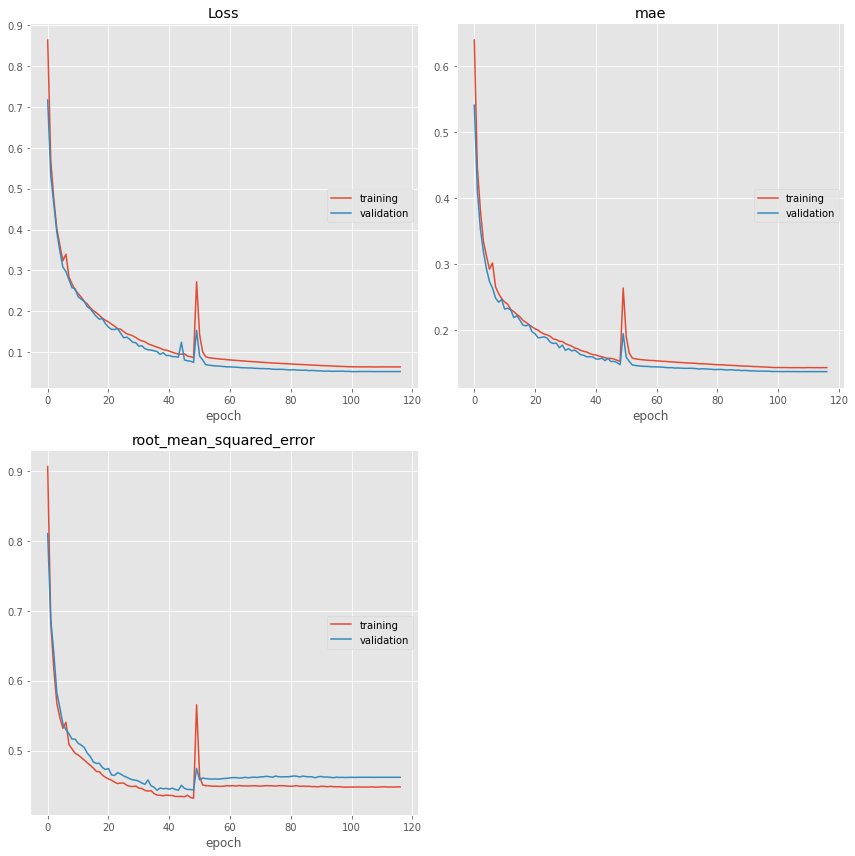

Loss
	training         	 (min:    0.064, max:    0.864, cur:    0.064)
	validation       	 (min:    0.053, max:    0.717, cur:    0.053)
mae
	training         	 (min:    0.143, max:    0.639, cur:    0.143)
	validation       	 (min:    0.137, max:    0.541, cur:    0.137)
root_mean_squared_error
	training         	 (min:    0.432, max:    0.906, cur:    0.448)
	validation       	 (min:    0.443, max:    0.810, cur:    0.462)
80/80 [==============================] - 32s 401ms/step - loss: 0.0640 - root_mean_squared_error: 0.4480 - mae: 0.1429 - val_loss: 0.0527 - val_root_mean_squared_error: 0.4618 - val_mae: 0.1369 - lr: 1.0000e-09


In [19]:
compile_and_fit(model, train_ds, val_ds, epochs=1000, patience_es=15, patience_lr=3)

In [28]:
def plot_result(model, scaler, Pmax_params, n_cols=5):
    for ds in (train_ds, val_ds):
        for X, y in ds.take(1):
            X = X[:n_cols]
            y = y[:n_cols]
        
        inputs = [pd.DataFrame(inverse_scale(d, scaler), columns=cols) for d in X]
        trues  = [pd.DataFrame(inverse_scale(d, scaler), columns=cols) for d in y]
        preds  = [pd.DataFrame(inverse_scale(d, scaler), columns=cols) for d in model.predict(X, verbose=0)]
        
        for input, pred in zip(inputs, preds):
            pred['TurbID'] = input['TurbID'].round().values
#             pred['Patv']   = compute_Pmax(pred, **Pmax_params)

        n_rows = X.shape[-1]
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(40, 20))
        for ax_col, col in zip(axes, cols):
            for idx_row, (ax, true, pred) in enumerate(zip(ax_col, trues, preds)):
                ax.plot(true[col], label='true')
                ax.plot(pred[col], label=f'pred ({np.mean(abs(pred[col]-true[col])):.3f})')
                ax.fill_between(range(len(true[col])), true[col], pred[col], alpha=0.1, color='b')
                ax.set_xticklabels([])
                ax.legend()
                if idx_row == 0:
                    ax.set_ylabel(col)
        fig.tight_layout()
        plt.show()

In [21]:
Pmax_params = {
    'constants'       : compute_Pmax_constants(d),
    'clipping_min_val': 0,
    'clipping_max_val': 1500
}

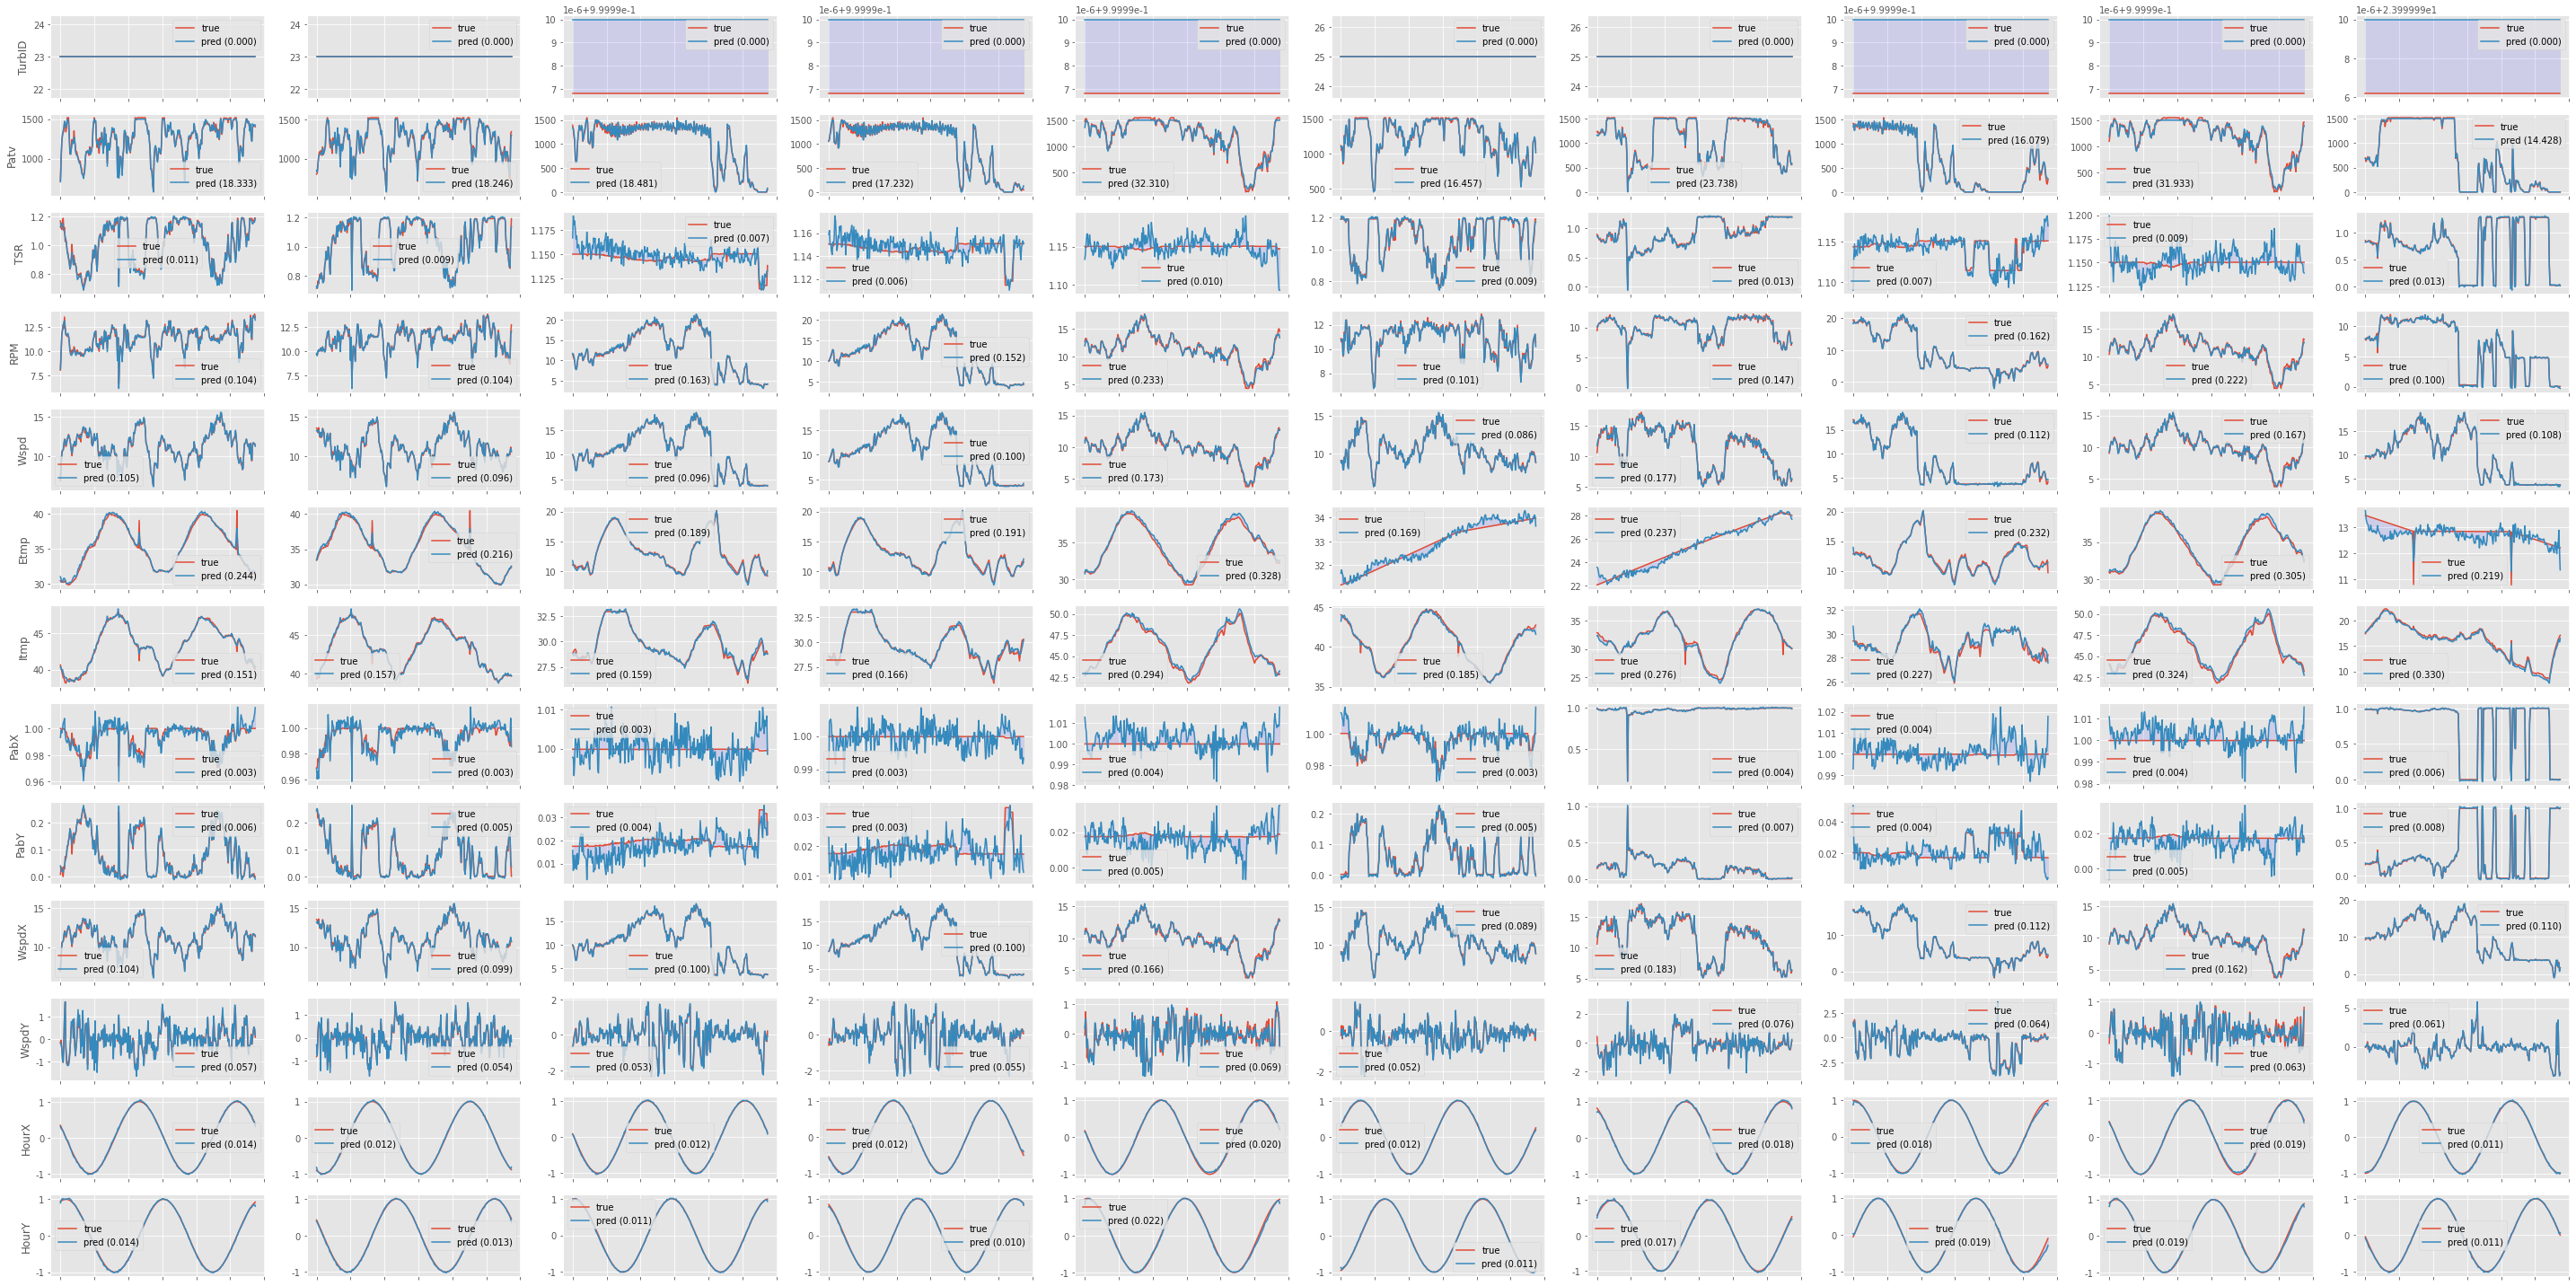

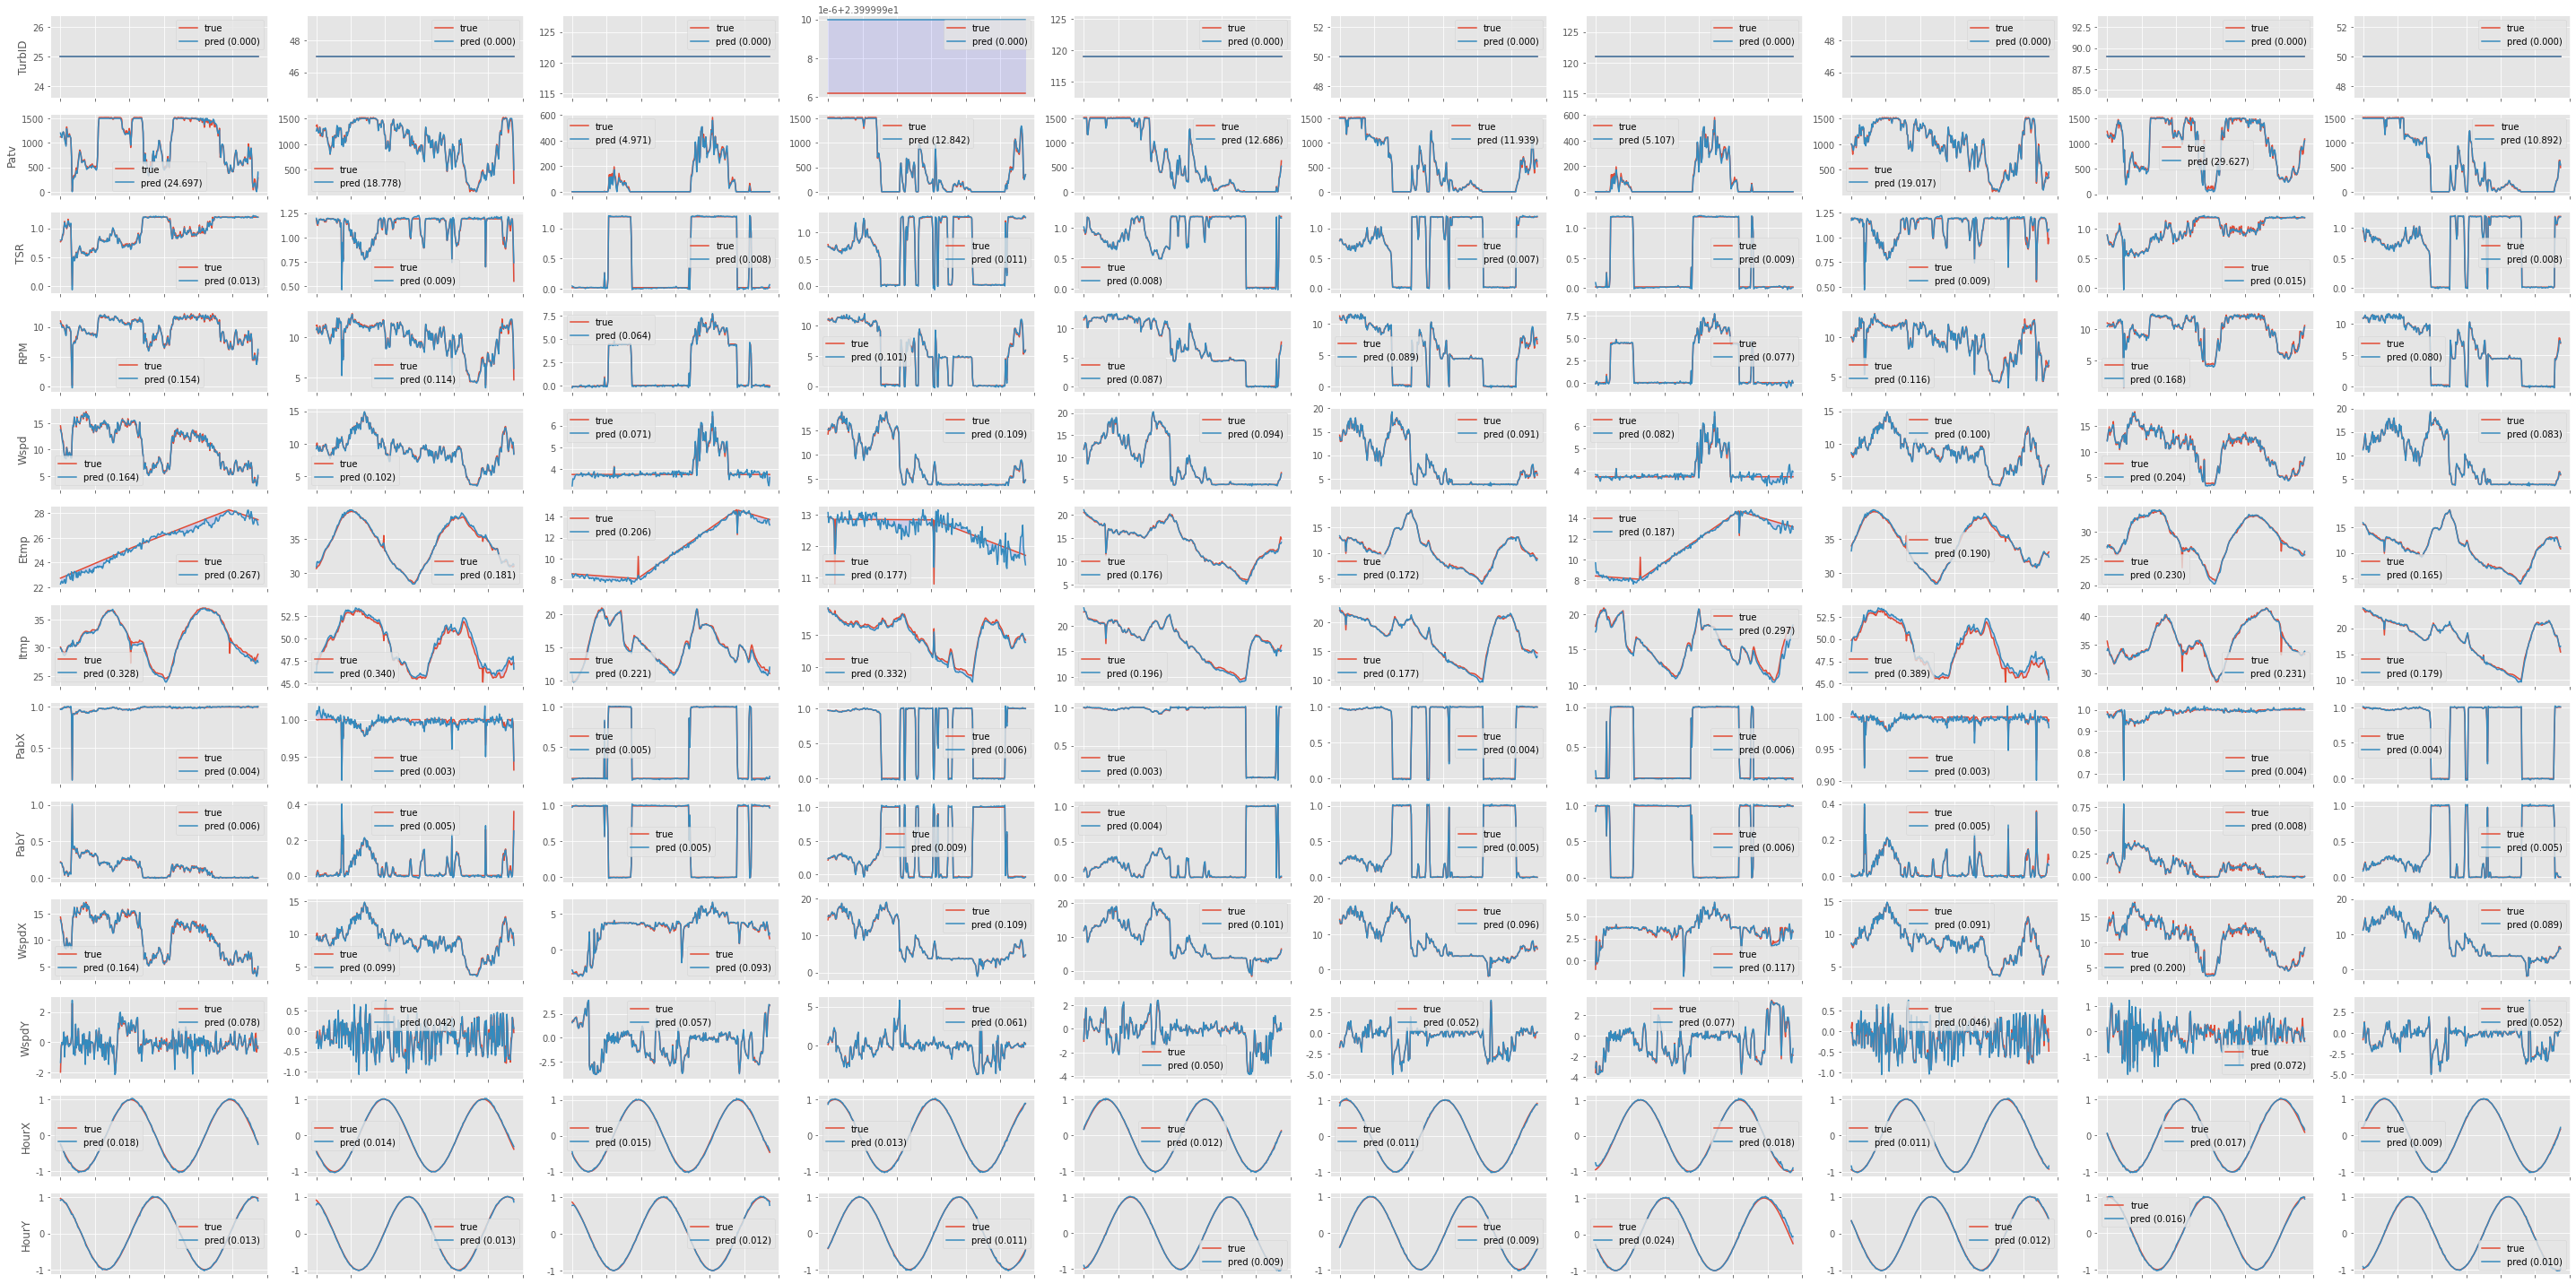

In [29]:
plot_result(model, scaler, Pmax_params, n_cols=10)

In [23]:
def compute_test_Patv(model, test_x, test_ds, cols, Pmax_params):
    X      = pd.concat(test_x)
    y_pred = inverse_scale(model.predict(test_ds), scaler).reshape(-1, X.shape[-1])
    y_pred = pd.DataFrame(y_pred, columns=cols)

#     y_pred['TurbID'] = X['TurbID'].round().values
#     y_pred['Patv']   = compute_Pmax(y_pred, **Pmax_params)
    return y_pred['Patv']

sample_submission['Patv'] = compute_test_Patv(model, test_x, test_ds, cols, Pmax_params)
sample_submission.to_csv(join(PATH.output, f"{exp_name}.csv"), index=False)

134/134 [==============================] - 21s 155ms/step


---

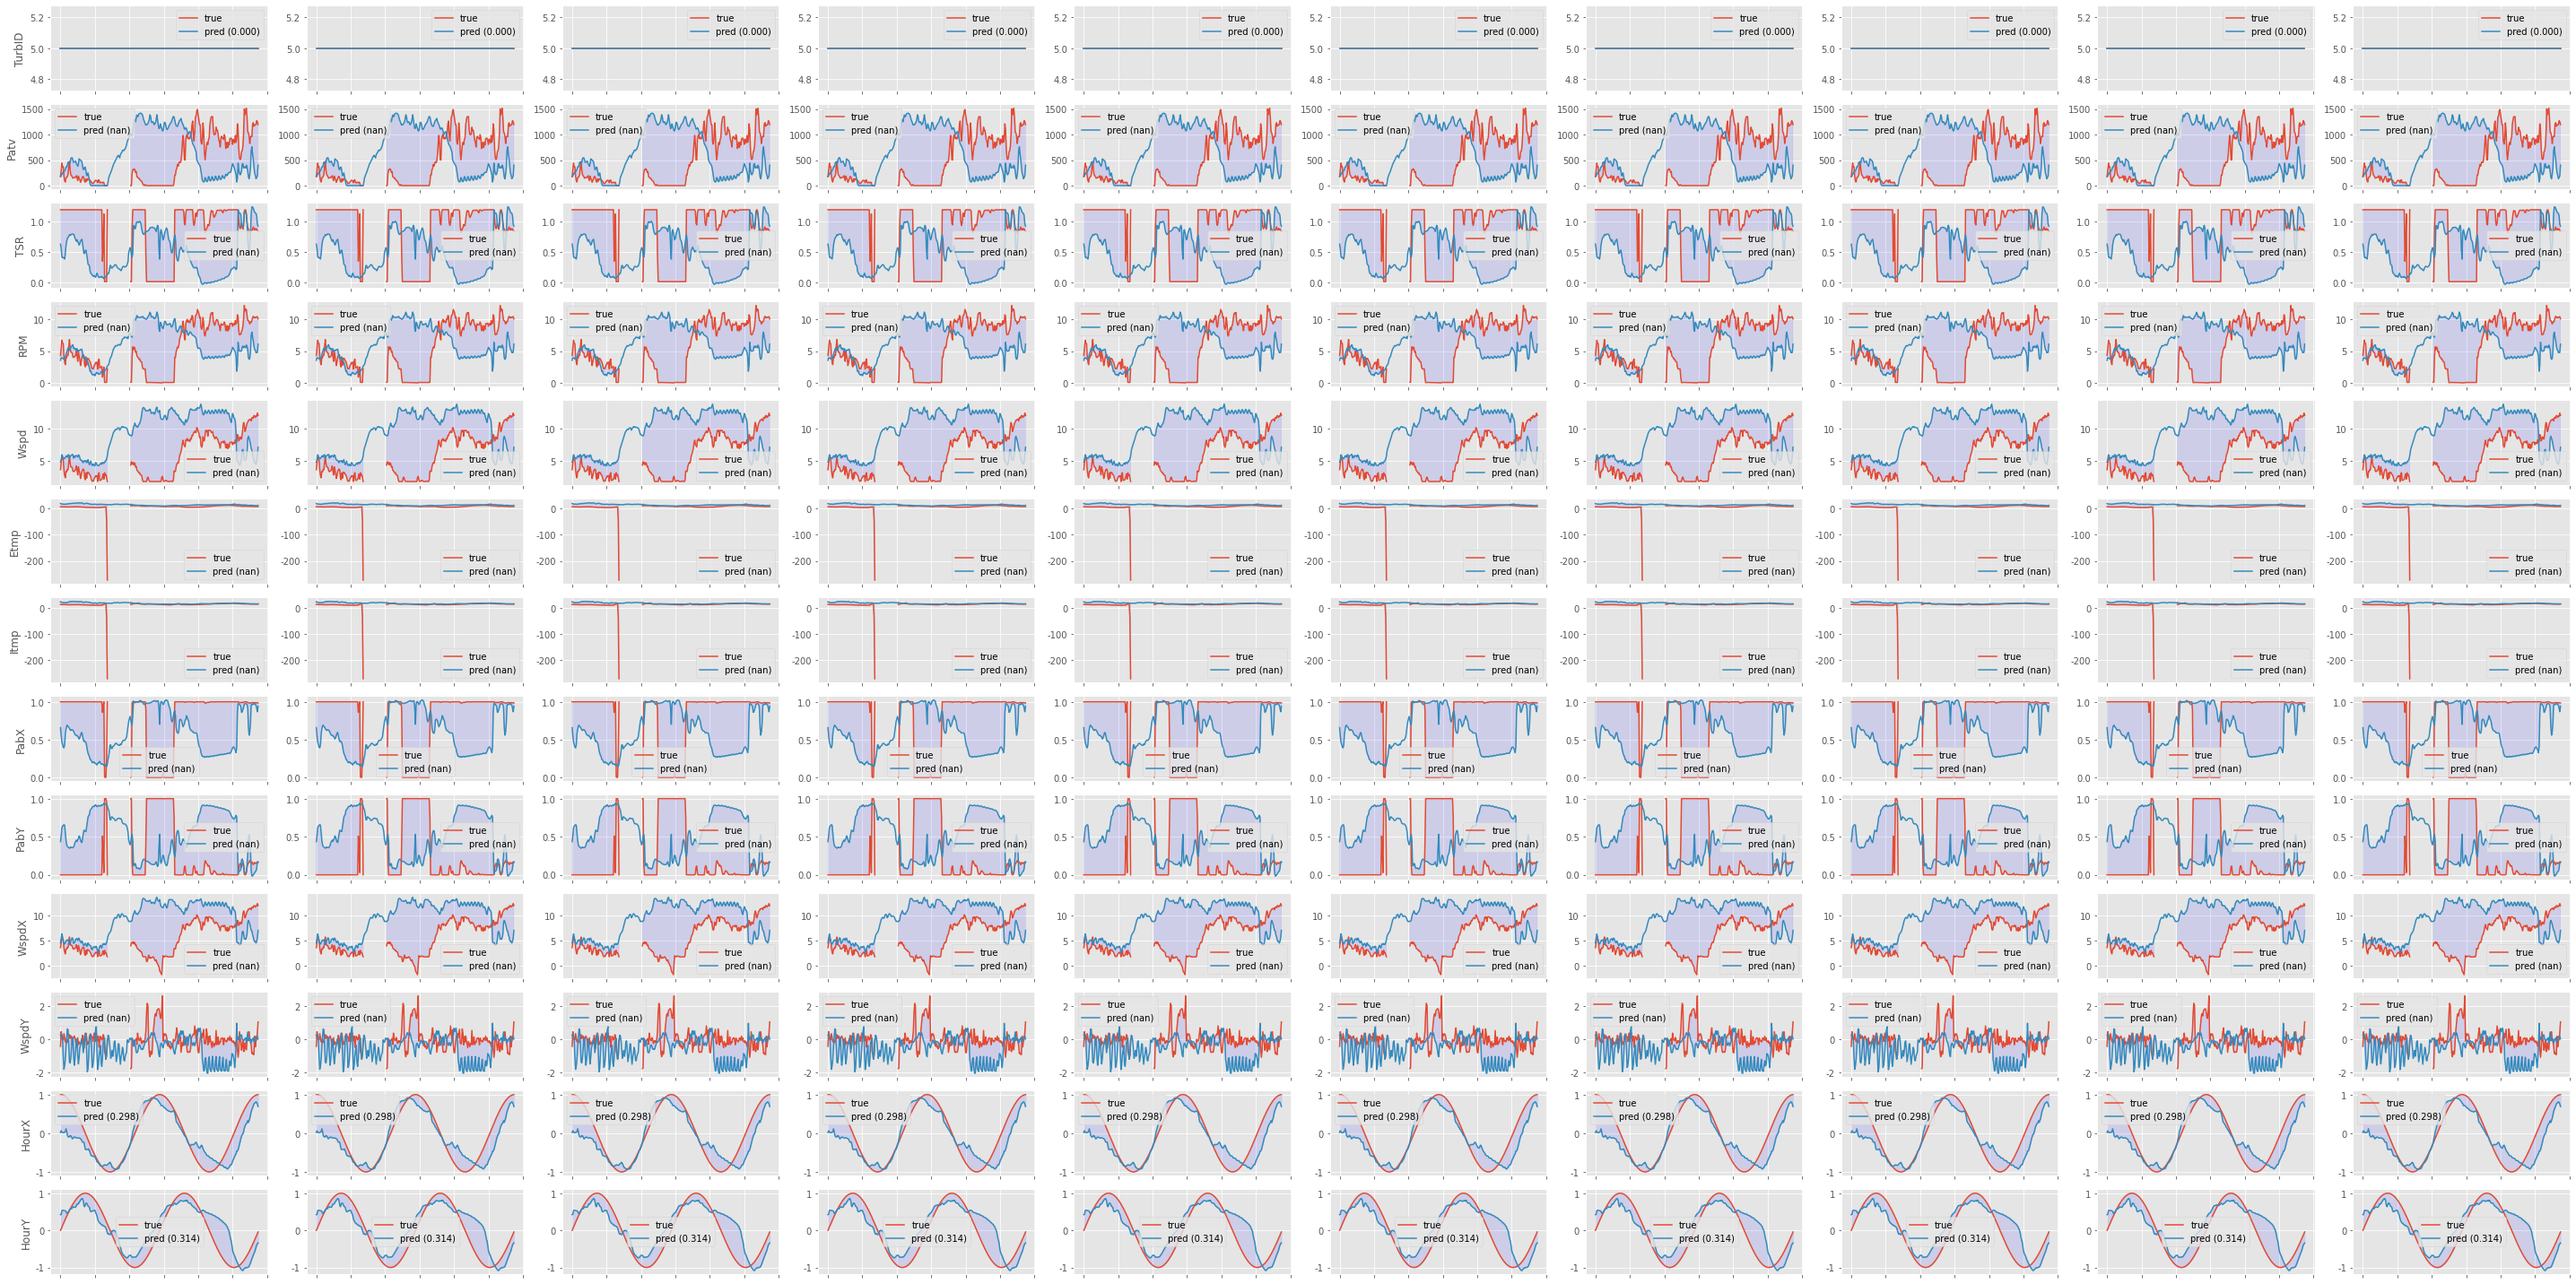

In [143]:
def plot_test_result(model, test_data, n_cols=5):
    y = process_features(test_data).reset_index(drop=True)
    p = pd.concat([pd.DataFrame(inverse_scale(d, scaler), columns=cols) for d in model.predict(test_ds, verbose=0)]).reset_index(drop=True)
    p['TurbID'] = y['TurbID'].values
    
    n_rows = len(cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(40, 20))
    for ax_col, col in zip(axes, cols):
        for idx_row, ax in enumerate(ax_col):
            true = y.query(f"TurbID == {idx_row+1}")[col].values
            pred = p.query(f"TurbID == {idx_row+1}")[col].values

            ax.plot(true, label='true')
            ax.plot(pred, label=f'pred ({np.mean(abs(pred-true)):.3f})')
            ax.fill_between(range(len(true)), true, pred, alpha=0.1, color='b')
            ax.set_xticklabels([])
            ax.legend()
            if idx_row == 0:
                ax.set_ylabel(col)
    fig.tight_layout()
    plt.show()

full_data = pd.read_csv(join(PATH.input, 'wtbdata_245days.csv'))
test_data = full_data[(201 <= full_data['Day']) & (full_data['Day'] <= 202)]
plot_test_result(model, test_data, 10)